# Instructions

To run this solver, please enter the wanted imbalance workload boundaries in the hyperparameters cell along as if you want to allow or not the partial allocation of bricks between sellers.
Then, run the jupyter notebook and go see the results in the last cell.

You will of course need the dependencies presented in the next cell. In particular, you will need to install pulp.

# Dependencies

In [1]:
import pandas as pd
import numpy as np
import random
from scipy import optimize as spopt
import matplotlib.pyplot as plt
import pulp

## Hyperparameters

In [2]:
DISTANCE_DATASET_PATH = "distances.xlsx"
INDEX_VALUES_DATASET_PATH = "index_values.csv"
INITIAL_DISTRIBUTION_DATASET_PATH = "initial_distribution.txt"
N_SELLERS = 4
N_BRICKS = 22

MAX_IMBALANCE_WORKLOAD = 1.2
MIN_IMBALANCE_WORKLOAD = 0.8

PARTIAL = False

# Dataset loader

In [3]:
class Dataset:
    def __init__(self, distance_dataset_path, index_values_dataset_path, initial_distribution_dataset_path):
        # Store dataset path
        self.distance_dataset_path = distance_dataset_path
        self.index_values_dataset_path = index_values_dataset_path
        self.initial_distribution_dataset_path = initial_distribution_dataset_path
        
        # Read dataset
        self.read_distances()
        self.read_index_values()
        self.read_initial_distribution()
    
    def read_distances(self):
        """
        Load and store the data from the excel sheet provided in the object
        """
        # Load first sheet 
        brick_bureau = pd.read_excel(self.distance_dataset_path, skiprows=[0], sheet_name=0, header=0, index_col=1, dtype=str)
        # Drop empty cells of the first column
        brick_bureau = brick_bureau.drop(labels=brick_bureau.columns[0], axis=1)
        
        # Load second sheet
        brick_brick = pd.read_excel(self.distance_dataset_path, sheet_name=1, header=1, index_col=1, dtype=str)
        # Drop emty cells of the first column
        brick_brick = brick_brick.drop(labels=brick_brick.columns[0], axis=1)
        
        # Store in self
        self.brick_bureau = brick_bureau
        self.brick_brick = brick_brick
        
        
    def read_index_values(self):
        """ Read index values, les_v
        """
        self.index_values = np.genfromtxt(self.index_values_dataset_path, delimiter=',')
    
    def read_initial_distribution(self):
        """ Read initial state of bricks distribution betweek sellers: les_a
        """
        with open(self.initial_distribution_dataset_path, "r") as file:
            raw_data = file.read().split("\n")
            # remove header
            raw_data.pop(0)
            initial_distribution = []
            for line in raw_data:
                line.replace(" ", "")
#                 id_seller = line.split(":")[0]
                les_id_bricks = line.split(":")[1].split(",")
                initial_distribution.append(les_id_bricks)
        
        les_a = np.zeros((N_SELLERS, N_BRICKS))
        for id_seller in range(len(initial_distribution)):
            for id_brick in initial_distribution[id_seller]:
                les_a[id_seller, int(id_brick)-1] = 1
        
        self.initial_affectation = les_a
        
    
    def disp_dataset(self):
        for dataset in [self.brick_brick, self.brick_brick, self.index_values, self.initial_affectation]:
            print("")
            print("="*20)
            print(dataset)
    
        
        
dataset = Dataset(DISTANCE_DATASET_PATH, INDEX_VALUES_DATASET_PATH, INITIAL_DISTRIBUTION_DATASET_PATH)

In [4]:
# dataset.disp_dataset()

# Problem definition

### VARIABLES
- $x_{ij}$ ; = 1 if seller `i` is allocated to brick `j`, 0 otherwise.  

### PARAMETERS
- $d_{ij}$ ; distance from office of seller `i` to the brick `j`  
- $v_j$ ; index value of the `j` brick
- $a_{ij}$ ; = 1 if seller `i` was originally allocated to brick `j`, 0 otherwise.  


## Minimize total distance traveled

We want to minimize the total traveled distance, then we want to minimize:  
$\underset{i=1}{\overset{4}{\sum}}\underset{j=1}{\overset{22}{\sum}}x_{ij}d_{ij}$  

## Minimize distruption

We want to minimize the changes from the previous model to the new one, leading to minimizing:  
$\underset{i=1}{\overset{4}{\sum}}\underset{j=1}{\overset{22}{\sum}}x_{ij}(1-a_{ij})v_j$    

- x: Matrix of shape number_of_seller=4 * number_of_bricks=22 with 0 or 1
- a: Same shape than x
- d: Matrix of shape number_of_seller=4 * number_of_bricks=22 with float

## Domain

$\forall i \in [1, 4], \forall j \in [1, 22], x_{ij} \in \{0, 1\}$

## Constraints

- 1 brick affectation to 1 seller  

$\forall j \in [0, 22], \underset{i=1}{\overset{4}{\sum}}x_{ij} = 1$

- Work imbalance between 80% and 120%:  

Seeing work imbalance as a constraint:  
$\forall i\in\{1, 2, 3, 4\}, x : \rightarrow \left(\frac{\underset{j=1}{\overset{22}{\sum}} x_{ij}v_j}{\frac{1}{4} \underset{j=1}{\overset{22}{\sum}} v_j}\right)$ must be $\geq 0.8$ and $\leq 1.2$


## Tools

In [12]:
class Tools:
    @staticmethod
    def get_total_workload(les_v):
        return np.sum(les_v)
    
    @staticmethod
    def flatten(les_x):
        """ Flatten a numpy array"""
        return les_x.reshape(-1)
    
    @staticmethod
    def reshape(les_x):
        """ Reshape a numpy array to the shape (N_SELLERS, N_BRICKS)"""
        
        if les_x.shape != (N_SELLERS, N_BRICKS):
            les_x = les_x.reshape((N_SELLERS, N_BRICKS))
        return les_x
    
    @staticmethod
    def one_ization(to_one_ize):
        """ If given matrix have [i,j] > 0, return matrix will have [i, j] == 1 
        :param to_one_ize: numpy matrix, matirx to one_ize
        :return one_ize: numpy matrix, one_ization
        """
        
        return np.where(to_one_ize > 0, 1, 0)
    

## Costs

In [13]:
class Cost:
    
    def __init__(self, les_d, les_v, les_a):
        self.les_d = les_d
        self.les_v = les_v
        self.les_a = les_a
        self.total_workload = Tools.get_total_workload(self.les_v)
        
        
    def cost_distance(self, les_x, normalized=True, partial=False):
        """ Return cost regarding distances
        :param les_x: matrix numpy, with x[i, j] set to 1 if seller i have to cover brick j
        
        :return cost: cost value regarding distances
        """
        
        if partial:
            les_x = Tools.one_ization(les_x)
        
        total_distances = np.sum(les_x * self.les_d)
        
        if normalized:
            return total_distances / np.sum(self.les_d)
        else:
            return total_distances
        
    
    def cost_disruption(self, les_x, normalized = True, partial=False):
        """ Return cost regarding disruption
        :param alpha: float default=0.5, weight to put on the distance cost regarding disruption cost
        :paam normalized: boolean, default=True, set to false to 
        :param partial: boolean, default=False, set to true if you want to allow partial brick assignment
        """
        
        if partial:
            les_x = Tools.one_ization(les_x)
        
        total_disruption = np.sum(les_x*(1 - self.les_a)*np.array([self.les_v]*4))
        if normalized:
            return total_disruption / np.sum(np.array([self.les_v]*4))
        else:
            return total_disruption
    
    
    def general_cost_function(self, alpha=0.5, partial=False):
        """ Generate the objective function setted with the wanted alpha value
        :param alpha: float default=0.5, weight to put on the distance cost regarding disruption cost
        :param partial: boolean, default=False, set to true if you want to allow partial brick assignment
        """
        
        def cost_weight_distance_disruption(les_x):
            """Weighted cost function to minimize distance and disruption with provided alpha
            :param les_x: matrix numpy, with x[i, j] set to 1 if seller i have to cover brick j
            :param alpha: float, default=0.5, weight of the distance cost function (1-alpha is given to disruption)

            :return cost: weighted cost value with distances and disruption
            """

            les_x = Tools.reshape(les_x)

            return alpha*self.cost_distance(les_x, partial) + (1-alpha)*self.cost_disruption(les_x, partial)
        
        return cost_weight_distance_disruption
    
    

## Constraints

In [14]:
class Constraint:
    
    def __init__(self, les_d, les_v, les_a):
        self.les_d = les_d
        self.les_v = les_v
        self.les_a = les_a
        self.total_workload = Tools.get_total_workload(self.les_v)
    
    
    def const_imbalance_workload(self, les_x):
        """ Return ratio of imbalance: 1 means perfect balance, 1.2 means 120% of average work"""
        return np.sum(les_x * np.array([self.les_v]*N_SELLERS), axis=1)/(0.25*self.total_workload)
    
    
    def const_unity_allocation(self, les_x):
        return np.sum(les_x, axis=0)
    
        

## Optimizer

In [15]:
class Optimizer:
    def __init__(self, coster, constrainer):
        self.coster = coster
        self.constrainer = constrainer
    
    
    def const_1(self, les_x):
        """ Constrain regarding 'every brick is allocated to 1 seller' """
        
        les_x = Tools.reshape(les_x)
        
        return Tools.flatten(self.constrainer.const_unity_allocation(les_x) - 1)
    
    
    def const_2(self, les_x):
        """ Constrain regarding lazier worker is not working less than 80% of average """
        
        les_x = Tools.reshape(les_x)
        
        return Tools.flatten(self.constrainer.const_imbalance_workload(les_x) - 0.8)
    
    
    def const_3(self, les_x):
        """ Constrain regarding the bester worker is not working more than 120% of average """
        
        les_x = Tools.reshape(les_x)
        
        return Tools.flatten(1.2 - self.constrainer.const_imbalance_workload(les_x))
    
    def const_4(self, les_x):
        """ Ensure we end up with kind of integers"""
        #return np.sum(les_x) - N_BRICKS
        return 0.005 - np.abs(np.round(les_x, 0) - les_x)
    
    def const_5(self, les_x):
        """ Ensure max affectation is 1"""
        # return Tools.flatten(1 - np.max(les_x))
        return Tools.flatten(1 - les_x)
    
    def const_6(self, les_x):
        """ Ensure min affectation is 0"""
        #return Tools.flatten(np.min(les_x))s
        return Tools.flatten(les_x)
    
    
    def minimize(self, fun, les_x0):
        
        # Let's define constraints. For eq, have to be equal to 0. For ineq, have to be positive.
        cons = [
                {'type':'eq', 'fun': self.const_1},
                {'type':'ineq', 'fun': self.const_2},
                {'type':'ineq', 'fun': self.const_3},
                {'type':'ineq', 'fun': self.const_4},
                {'type':'ineq', 'fun': self.const_5},
                {'type':'ineq', 'fun': self.const_6}
        ]
        
        return spopt.minimize(fun, les_x0, constraints=cons, method='SLSQP', options={'disp': True})
    
    def minimize_pulp(self, fun, les_x0, partial=False, verbose=True):
        
        prob = pulp.LpProblem("Pfizer case", pulp.LpMinimize)
        if partial:
            les_x = np.array([[pulp.LpVariable("x"+str(i)+","+str(j), 0, 1) for j in range(N_BRICKS)] for i in range(N_SELLERS)])
        else:
            les_x = np.array([[pulp.LpVariable("x"+str(i)+","+str(j), 0, 1, pulp.LpBinary) for j in range(N_BRICKS)] for i in range(N_SELLERS)])
        
        obj = fun(les_x)
        prob += obj
        
        les_unity_allocation = self.constrainer.const_unity_allocation(les_x)
        for unity_allocation in les_unity_allocation:
            # Lets check that each brick work is completed
            prob += unity_allocation == 1

        les_workload = self.constrainer.const_imbalance_workload(les_x)
        for workload in les_workload:
            # Lets check that we are not exceeding a 20% imbalance in workload
            prob += workload <= MAX_IMBALANCE_WORKLOAD
            prob += workload >= MIN_IMBALANCE_WORKLOAD

        prob.solve()
        if verbose:
            print("Solution is", pulp.LpStatus[prob.status])
        sol = np.zeros_like(les_x0)
        for v in prob.variables():
            i = int(v.name[1])
            j = int(v.name[3:])
            sol[i,j]=v.varValue
        return sol
    

Optimizing with alpha= 0.5
Solution is Optimal

Original x
[[0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]]

Computed result
[[0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]

== Constraint test ==
Check imbalance workload
From [0.9507 1.3377 0.7048 1.0068]
To   [0.9548 1.1275 1.1149 0.8028]

== Cost test ==

>Total distances
From 187.41
To   154.63

>Total disruption
From 0.0
To   1.1227

>Alpha weighted normalized cost function
77.87635


Draw cost functions values regarding to alpha


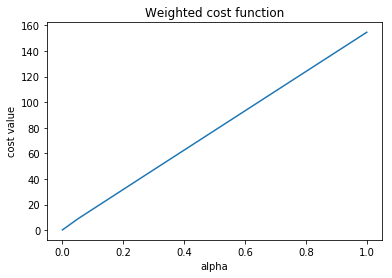

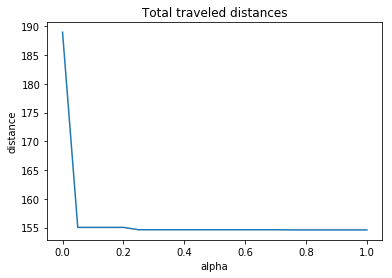

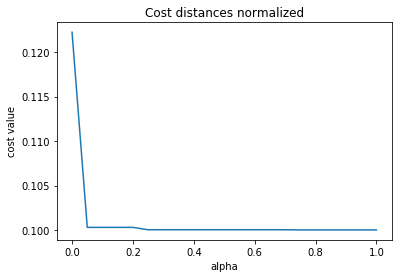

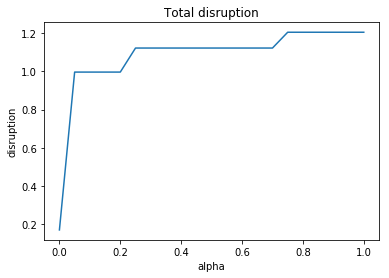

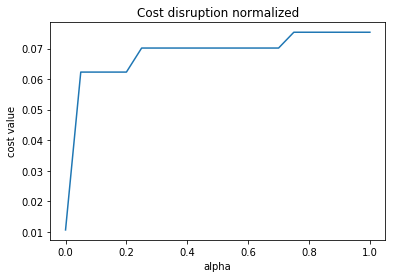

In [16]:
class Interface:
    
    def __init__(self):
        self.dataset = Dataset(DISTANCE_DATASET_PATH, INDEX_VALUES_DATASET_PATH, INITIAL_DISTRIBUTION_DATASET_PATH)
        self.les_d = self.get_les_d()
        self.les_v = self.get_les_v()
        self.les_a = self.get_les_a()
        self.les_x_test = self.generate_les_x_test()
        
        self.coster = Cost(les_d=self.les_d, les_v=self.les_v, les_a=self.les_a)
        
        self.constrainer = Constraint(les_d=self.les_d, les_v=self.les_v, les_a=self.les_a)
        
        self.optimizer = Optimizer(self.coster, self.constrainer)

    
    def get_les_d(self):
        """ Return value of distances betweek sellers office and bricks
        """
        les_d = np.array(self.dataset.brick_bureau, dtype=np.float).transpose()
        return les_d
    
    
    def get_les_v(self):
        """ Return index values of brickes, with les_v[j] = index value of brick j
        """
        les_v = self.dataset.index_values
        return les_v

    
    def get_les_a(self):
        """ Return les a"""
        les_a = self.dataset.initial_affectation
        return les_a
    
    
    def generate_les_x_test(self):
        """
        To test cost function, we need to generate a false affectation of seller to bricks.
        Thus, we create a random affectation.
        """
        # Create a x_test matrix, inversed shape, with line corresponding to bricks, columns to sellers
        les_x_test = np.zeros((N_BRICKS, N_SELLERS))
        
        # Put one 1 per line, to affect each brick to a seller
        for id_line in range(len(les_x_test)):
            id_one = random.randint(0, len(les_x_test[id_line]) - 1)
            les_x_test[id_line, id_one] = 1
        
        # Lets transpose the matrix, as we want seller as rows.
        les_x_test = les_x_test.transpose()
        return les_x_test
    
    
    def test_cost_distance(self):
        print("Test cost distance")
        print(self.coster.cost_distance(les_x=self.les_x_test))
        
        
    def test_cost_imbalance_worload(self):
        print("Test cost imbalance")
        print(self.coster.cost_imbalance_worload(les_x=self.les_x_test))
        
    def test_cost_distruption(self):
        print("Test cost disruption")
        print(self.coster.cost_disruption(les_x=self.les_x_test))
        
    def test_const_imbalance_workload(self):
        print("Test const imbalance workload")
        print(self.constrainer.const_imbalance_workload(les_x=self.les_x_test))
        
    def test_const_unity_allocation(self):
        les_unit = []
        for j in range(N_BRICKS):
            les_unit.append(self.constrainer.const_unity_allocation(les_x=self.les_x_test, brick_index=j))
        
        print(les_unit)
        
    
    def optimize(self, alpha=0.5):
        """ Run optimization using Scipy implementation
        :param alpha: float default=0.5, weight to put on the distance cost regarding disruption cost
        """
        
        self.fun = self.coster.general_cost_function(alpha)
        les_x0 = self.les_x_test
        res = self.optimizer.minimize(self.fun, les_x0)
        self.sol = Tools.reshape(np.where(res.x > 0.5, 1, 0))
        return self.sol
    
    def optimize_pulp(self, alpha=0.5, partial=False, verbose=True):
        """ Run optimization using pulp sover
        :param alpha: float default=0.5, weight to put on the distance cost regarding disruption cost
        :param partial: boolean, default=False, set to true if you want to allow partial brick assignment
        :param verbose: boolean, default=True, display the solver state
        :return sol: np.matrix, solution of the optimizer, also written in self.sol attribute
        
        """
        if verbose:
            print("Optimizing with alpha=", alpha)
        
        self.fun = self.coster.general_cost_function(alpha=alpha, partial=partial)
        les_x0 = self.les_x_test
        sol = self.optimizer.minimize_pulp(self.fun, les_x0, partial=partial, verbose=verbose)
        self.sol = sol
        self.partial = partial
        return self.sol
    
    def print_results(self):
        """ Print results of optimization and interesting values, such as total traveled distances,
        before and after optimization"""
        
        print("\nOriginal x")
        print(self.coster.les_a)
        
        print("\nComputed result")

        print(self.sol)
        if self.partial:
            print("rounded solution:")
            print(np.round(self.sol, 2))
        
        
        print("\n== Constraint test ==")
        
        print("Check imbalance workload")
        print("From", self.constrainer.const_imbalance_workload(self.coster.les_a))
        print("To  ", self.constrainer.const_imbalance_workload(self.sol))
        
        print("\n== Cost test ==")
        print("\n>Total distances")
        print("From", self.coster.cost_distance(self.coster.les_a, normalized=False))
        print("To  ", self.coster.cost_distance(self.sol, normalized=False))
        
        print("\n>Total disruption")
        print("From", self.coster.cost_disruption(self.coster.les_a, normalized=False))
        print("To  ", self.coster.cost_disruption(self.sol, normalized=False))
        
        print("\n>Alpha weighted normalized cost function")
        print(self.fun(self.sol))
        print("\n")
        
    def draw_optimize(self, pulp=True):
        """ Draw plots to understand the evolutions of optimizer when looking at alpha values"""
        
        print("Draw cost functions values regarding to alpha")
        
        les_alpha = []
        les_disruption = []
        les_disruption_normalized = []
        les_distance = []
        les_distance_normalized = []
        les_cost_weighted = []
        
        step = 0.05
        for alpha in np.arange(0, 1 + step, step):
            alpha = round(alpha, len(str(step)))
            les_alpha.append(alpha)
            
            if pulp:
                sol = self.optimize_pulp(alpha, verbose=False)
            else:
                sol = self.optimize(alpha)
            
            les_distance_normalized.append(self.coster.cost_distance(sol, normalized=True))
            les_distance.append(self.coster.cost_distance(sol, normalized=False))
            les_disruption_normalized.append(self.coster.cost_disruption(sol, normalized=True))
            les_disruption.append(self.coster.cost_disruption(sol, normalized=False))
            les_cost_weighted.append(self.fun(sol))
        
        plt.figure()
        plt.plot(les_alpha, les_cost_weighted)
        plt.title("Weighted cost function")
        plt.xlabel("alpha")
        plt.ylabel("cost value")

        plt.figure()
        plt.title("Total traveled distances")
        plt.xlabel("alpha")
        plt.ylabel("distance")
        plt.plot(les_alpha, les_distance)
        
        plt.figure()
        plt.title("Cost distances normalized")
        plt.xlabel("alpha")
        plt.ylabel("cost value")
        plt.plot(les_alpha, les_distance_normalized)
        
        plt.figure()
        plt.title("Total disruption")
        plt.xlabel("alpha")
        plt.ylabel("disruption")
        plt.plot(les_alpha, les_disruption)
        
        plt.figure()
        plt.title("Cost disruption normalized")
        plt.xlabel("alpha")
        plt.ylabel("cost value")
        plt.plot(les_alpha, les_disruption_normalized)
        
        plt.show()
        
            
    
interfacer = Interface()
# interfacer.test_cost_distance()
# interfacer.test_cost_imbalance_worload()
# interfacer.test_cost_distruption()

# interfacer.test_const_imbalance_workload()
# interfacer.test_const_unity_allocation()

# interfacer.optimize()
# interfacer.print_results()
# interfacer.draw_optimize()

interfacer.optimize_pulp(partial=PARTIAL)
interfacer.print_results()
interfacer.draw_optimize()